# Bibliotecas

## Instalação

In [ ]:
## Base library Installation

# Install rich for better and more readable printing
!uv pip install rich

## TabPFN Installation optimized for Google Colab
# Install the TabPFN Client library
!uv pip install tabpfn-client

# Install TabPFN extensions for additional functionalities
!uv pip install tabpfn-extensions[all]

# Install tabpfn
!uv pip install tabpfn

Using Python 3.12.12 environment at: /usr
Audited 1 package in 215ms
Using Python 3.12.12 environment at: /usr
Resolved 33 packages in 344ms
Prepared 4 packages in 62ms
Installed 4 packages in 6ms
 + backoff==2.2.1
 + password-strength==0.0.3.post2
 + sseclient-py==1.8.0
 + tabpfn-client==0.2.8
Using Python 3.12.12 environment at: /usr
Resolved 96 packages in 732ms
Prepared 19 packages in 577ms
Uninstalled 1 package in 1ms
Installed 19 packages in 116ms
 + autogluon-common==1.4.0
 + autogluon-core==1.4.0
 + autogluon-features==1.4.0
 + autogluon-tabular==1.4.0
 + boto3==1.42.13
 + botocore==1.42.13
 + ecos==2.0.14
 + eval-type-backport==0.3.1
 + galois==0.4.8
 + jmespath==1.0.1
 + posthog==6.9.3
 - requests==2.32.4
 + requests==2.32.5
 + s3transfer==0.16.0
 + scikit-survival==0.26.0
 + shapiq==1.4.1
 + sparse-transform==0.2.1
 + tabpfn==6.2.0
 + tabpfn-common-utils==0.2.12
 + tabpfn-extensions==0.2.2
Using Python 3.12.12 environment at: /usr
Audited 1 package in 163ms


In [ ]:
!pip install -q huggingface_hub


## Importe das bibliotecas

In [ ]:
# Standard Library Imports

# TabPFN and Extensions

try:
    from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
        AutoTabPFNClassifier,
    )

    from tabpfn import TabPFNClassifier, TabPFNRegressor
except ImportError:
    raise ImportError(
        "Warning: Could not import TabPFN / TabPFN extensions. Please run installation above and restart the session afterwards (Runtime > Restart Session)."
    )

from google.colab import drive
import os

import numpy as np
import pandas as pd
from sklearn.metrics import (
    log_loss, mean_squared_error, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score, accuracy_score, roc_curve
)

from scipy.stats import ks_2samp
from tabpfn import TabPFNClassifier

# Data Science & Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns


# Notebook UI/Display
from IPython.display import Markdown, display
from rich.console import Console
from rich.panel import Panel
from rich.prompt import Prompt
from rich.rule import Rule

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Login e configuração do TabPFN

In [ ]:
from huggingface_hub import login
login()

In [ ]:
console = Console()

console.print(Panel.fit("[bold magenta]TabPFN Demo: Backend Selection[/bold magenta]"))
console.print("\nThis script can run TabPFN using one of two backends:")
console.print("  [bold]1. local:[/bold] Uses a local GPU (NVIDIA). Requires CUDA.")
console.print(
    "  [bold]2. client:[/bold] Uses the TabPFN API. Requires an internet connection and a free account."
)

backend = Prompt.ask(
    "\n[bold]Choose your backend[/bold] - If not field to enter is shown restart the cell.",
    choices=["client", "local"],
    default="client",
)

console.print(
    f"\You have selected the '[bold green]{backend}[/bold green]' backend."
)

console.print(Rule(f"[bold]Setting up [cyan]{backend}[/cyan] backend[/bold]"))

if backend == "local":
    !uv pip install huggingface_hub

    console.print("Attempting local backend setup...")
    import torch

    if not torch.cuda.is_available():
        console.print(
            "[bold red]Error:[/bold red] GPU device not found. For fast training, please enable GPU.",
            style="red",
        )
        console.print(
            "In Colab: Go to [bold]Runtime -> Change runtime type -> Hardware accelerator -> GPU.[/bold]",
            style="yellow",
        )
        raise SystemError("GPU device not found.")
    console.print(
        "[bold green] GPU is available.[/bold green] Importing local TabPFN library..."
    )

    from tabpfn import TabPFNClassifier, TabPFNRegressor

    console.print("[bold green] TabPFN (local) imported successfully.[/bold green]")
elif backend == "client":
    console.print("Attempting client backend setup...")
    console.print("Importing TabPFN client library...")
    from tabpfn_client import TabPFNClassifier, TabPFNRegressor, init

    init()
    console.print("[bold green] TabPFN (client) initialized.[/bold green]")

<>:17: SyntaxWarning: invalid escape sequence '\Y'
<>:17: SyntaxWarning: invalid escape sequence '\Y'
/tmp/ipython-input-3062174531.py:17: SyntaxWarning: invalid escape sequence '\Y'
  f"\You have selected the '[bold green]{backend}[/bold green]' backend."


╭────────────────────────────────╮
│ TabPFN Demo: Backend Selection │
╰────────────────────────────────╯

This script can run TabPFN using one of two backends:

1. local: Uses a local GPU (NVIDIA). Requires CUDA.

2. client: Uses the TabPFN API. Requires an internet connection and a free account.

Choose your backend - If not field to enter is shown restart the cell. [client/local] (client):

local


\You have selected the 'local' backend.

──────────────────────────────────────────── Setting up local backend ─────────────────────────────────────────────

Using Python 3.12.12 environment at: /usr
Audited 1 package in 90ms


Attempting local backend setup...

 GPU is available. Importing local TabPFN library...

 TabPFN (local) imported successfully.

# Extração do Dataset

In [ ]:
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/data_sets_classificacao_churn'

Mounted at /content/drive


In [ ]:
X_train = torch.tensor(pd.read_csv(f"{DATA_DIR}/X_train_over.csv").values.astype(np.float32), dtype=torch.float32)
y_train = torch.tensor(pd.read_csv(f"{DATA_DIR}/y_train_over.csv").values.astype(np.float32), dtype=torch.float32).squeeze(1)

X_val = torch.tensor(pd.read_csv(f"{DATA_DIR}/X_val_over.csv").values.astype(np.float32), dtype=torch.float32)
y_val = torch.tensor(pd.read_csv(f"{DATA_DIR}/y_val_over.csv").values.astype(np.float32), dtype=torch.float32).squeeze(1)

X_test = torch.tensor(pd.read_csv(f"{DATA_DIR}/X_test.csv").values.astype(np.float32), dtype=torch.float32)
y_test = torch.tensor(pd.read_csv(f"{DATA_DIR}/y_test.csv").values.astype(np.float32), dtype=torch.float32).squeeze(1)

# Funções

In [ ]:
def ks_cumulative(y_true, y_score, plot=True, title="KS Curve"):
    y_true = np.array(y_true)
    y_score = np.array(y_score)


    order = np.argsort(y_score)[::-1]
    y_true = y_true[order]


    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)


    cum_pos = np.cumsum(y_true == 1) / n_pos
    cum_neg = np.cumsum(y_true == 0) / n_neg


    ks_values = np.abs(cum_pos - cum_neg)
    ks = np.max(ks_values)
    ks_pos = np.argmax(ks_values)


    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(cum_pos, label="TPR (Cumulative)")
        plt.plot(cum_neg, label="FPR (Cumulative)")
        plt.axvline(ks_pos, color="red", linestyle="--", label=f"KS = {ks:.3f}")
        plt.xlabel("Samples sorted by score")
        plt.ylabel("Cumulative rate")
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()


    return ks

In [ ]:
def plot_roc(y, y_prob, title="ROC Curve"):

    fpr, tpr, _ = roc_curve(y, y_prob)
    auc = roc_auc_score(y, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def plot_conf_matrix(y_true, y_score, threshold=0.5, title="Confusion Matrix"):
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Não Churn", "Churn"],
                yticklabels=["Não Churn", "Churn"])
    plt.title("Matriz de Confusão - Teste")
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.show()

In [ ]:
def compute_metrics(y_true, y_score, threshold=0.5):
    y_pred = (y_score >= threshold).astype(int)


    return {
        "KS": ks_cumulative(y_true, y_score, plot=False),
        "ROC_AUC": roc_auc_score(y_true, y_score),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_score),
        "LogLoss": log_loss(y_true, y_score)
    }

# Experimento 1 - Modelo Base

                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.976329  0.999443  0.987194   0.976471  0.998448  0.010462   
Validation  0.488354  0.825060  0.652950   0.842014  0.376553  0.247786   
Test        0.486102  0.823009  0.794638   0.705882  0.387097  0.152854   

             LogLoss  
Train       0.046414  
Validation  0.780992  
Test        0.492610  


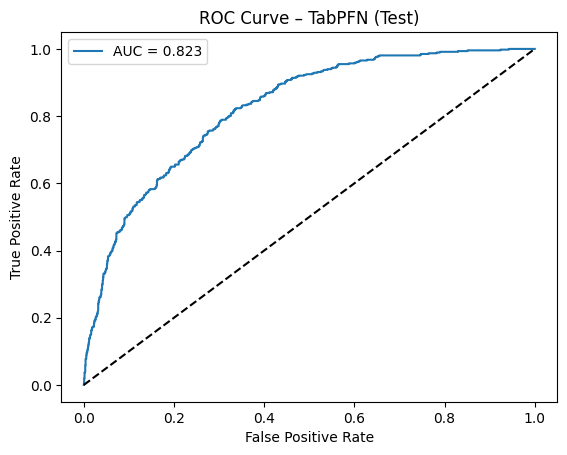

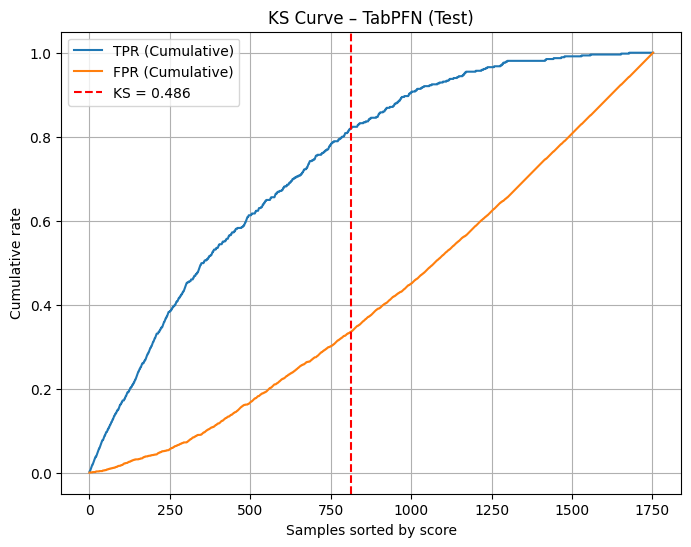

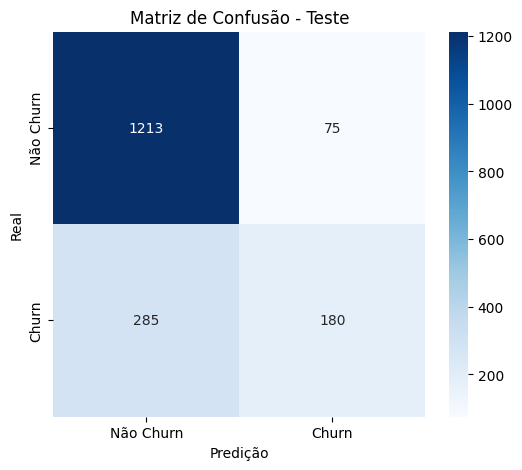

In [ ]:
# ---------- TREINAMENTO ----------
model = TabPFNClassifier()
model.fit(X_train, y_train)


# ---------- PREDIÇÕES ----------
y_train_score = model.predict_proba(X_train)[:, 1]
y_val_score = model.predict_proba(X_val)[:, 1]
y_test_score = model.predict_proba(X_test)[:, 1]


# ---------- MÉTRICAS ----------
metrics_train = compute_metrics(y_train, y_train_score)
metrics_val = compute_metrics(y_val, y_val_score)
metrics_test = compute_metrics(y_test, y_test_score)


metrics_df = pd.DataFrame([
metrics_train,
metrics_val,
metrics_test
], index=["Train", "Validation", "Test"])


print(metrics_df)


# ---------- GRÁFICOS (TESTE) ----------


plot_roc(y_test, y_test_score, "ROC Curve – TabPFN (Test)")
ks_cumulative(y_test, y_test_score, plot=True, title="KS Curve – TabPFN (Test)")
plot_conf_matrix(y_test, y_test_score, threshold=0.5, title="Confusion Matrix – TabPFN (Test)")

# Experimento 2 - Treinamento com melhor versão do modelo

In [ ]:
import itertools

available_models = [
    "tabpfn-v2-classifier.ckpt",
    "tabpfn-v2-classifier-gn2p4bpt.ckpt",
    "tabpfn-v2-classifier-llderlii.ckpt",
    "tabpfn-v2-classifier-od3j1g5m.ckpt",
    "tabpfn-v2-classifier-vutqq28w.ckpt",
    "tabpfn-v2-classifier-znskzxi4.ckpt",
    "tabpfn-v2-classifier-v2_default.ckpt",
]

best_ks = -1

for model_name in available_models:

    model = TabPFNClassifier(model_path=model_name)

    model.fit(X_train, y_train)

    preds = (y_val_pred_proba >= 0.5).astype(int)

    ks, _ = ks_2samp(
        preds[y_val == 0],
        preds[y_val == 1]
    )

    if ks > best_ks:
        best_ks = ks
        best_model = model_name

print("Melhor config:", best_model)


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-gn2p4bpt.ckpt:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-llderlii.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-od3j1g5m.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-vutqq28w.ckpt:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-znskzxi4.ckpt:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-v2_default.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Melhor config: tabpfn-v2-classifier.ckpt


In [ ]:
model = TabPFNClassifier(model_path='tabpfn-v2-classifier.ckpt')

print("Treinando TabPFN...")
model.fit(X_train, y_train)
print("Treino concluído!")

Treinando TabPFN...


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Treino concluído!


                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.960419  0.997756  0.978269   0.965621  0.991851  0.020623   
Validation  0.532609  0.838916  0.687500   0.836820  0.465839  0.217166   
Test        0.519480  0.837639  0.805476   0.703947  0.460215  0.142777   

             LogLoss  
Train       0.093789  
Validation  0.670848  
Test        0.448244  


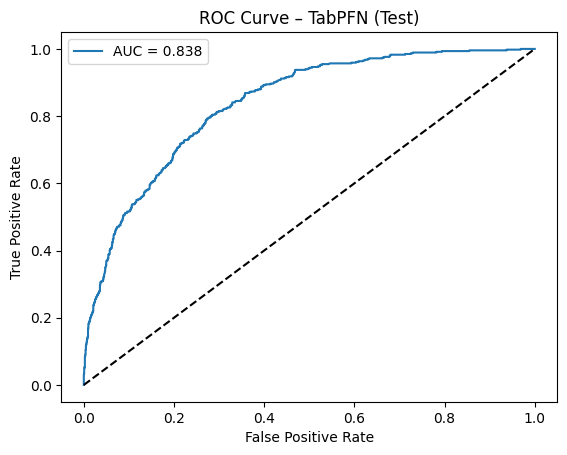

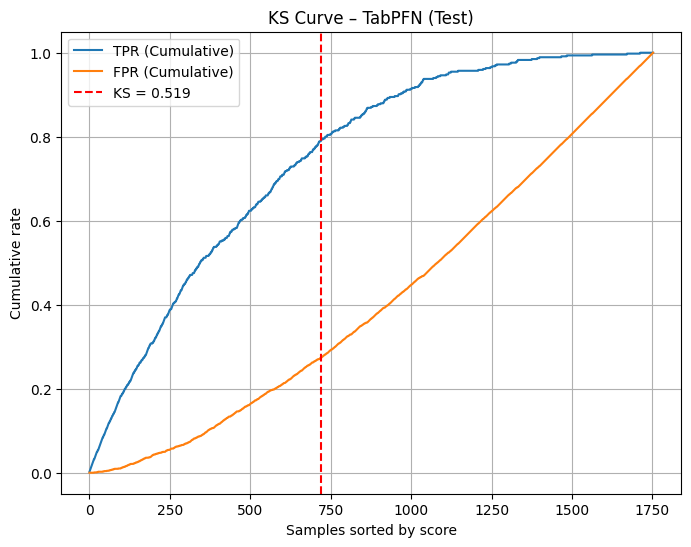

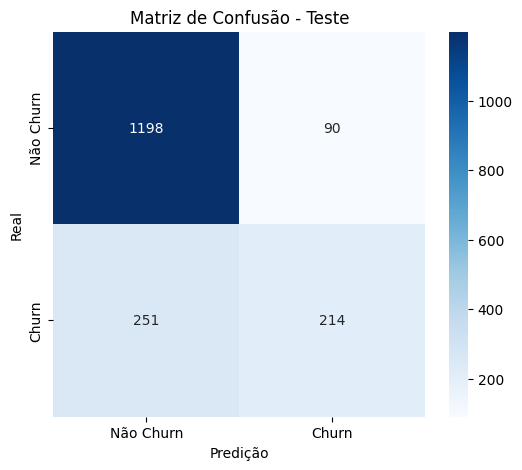

In [ ]:
# ---------- PREDIÇÕES ----------
y_train_score = model.predict_proba(X_train)[:, 1]
y_val_score = model.predict_proba(X_val)[:, 1]
y_test_score = model.predict_proba(X_test)[:, 1]


# ---------- MÉTRICAS ----------
metrics_train = compute_metrics(y_train, y_train_score)
metrics_val = compute_metrics(y_val, y_val_score)
metrics_test = compute_metrics(y_test, y_test_score)


metrics_df = pd.DataFrame([
metrics_train,
metrics_val,
metrics_test
], index=["Train", "Validation", "Test"])


print(metrics_df)


# ---------- GRÁFICOS (TESTE) ----------


plot_roc(y_test, y_test_score, "ROC Curve – TabPFN (Test)")
ks_cumulative(y_test, y_test_score, plot=True, title="KS Curve – TabPFN (Test)")
plot_conf_matrix(y_test, y_test_score, threshold=0.5, title="Confusion Matrix – TabPFN (Test)")

# Experimento 3 - Análise de desempenho em função do PCA

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.227784  0.649187  0.608265   0.608645  0.606519  0.232780   
Validation  0.194876  0.616176  0.591227   0.592157  0.586180  0.240790   
Test        0.236178  0.627763  0.610953   0.365217  0.632258  0.235807   

             LogLoss  
Train       0.657192  
Validation  0.675406  
Test        0.662990  


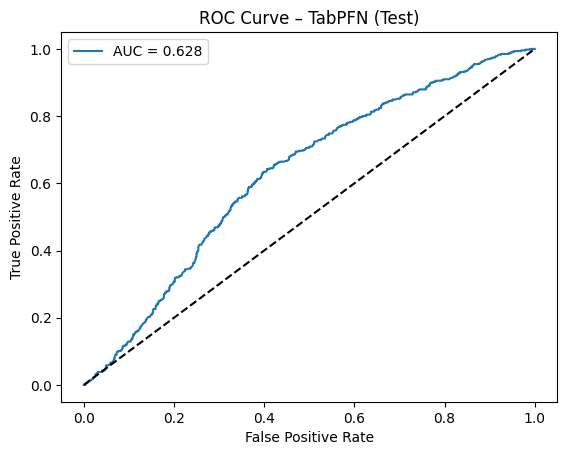

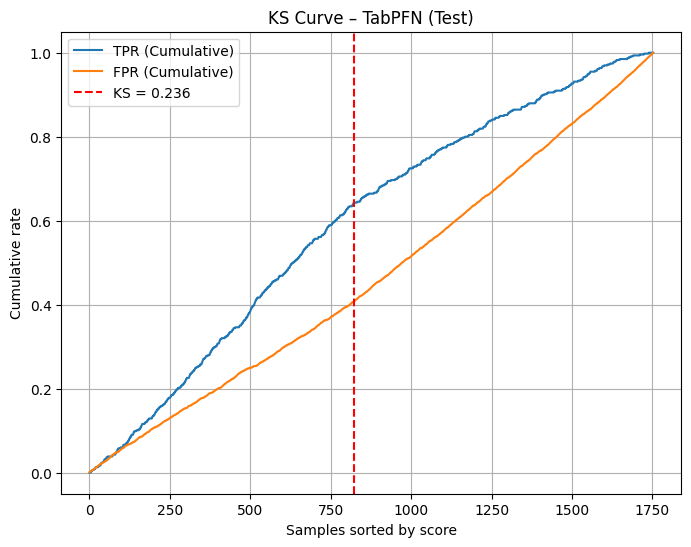

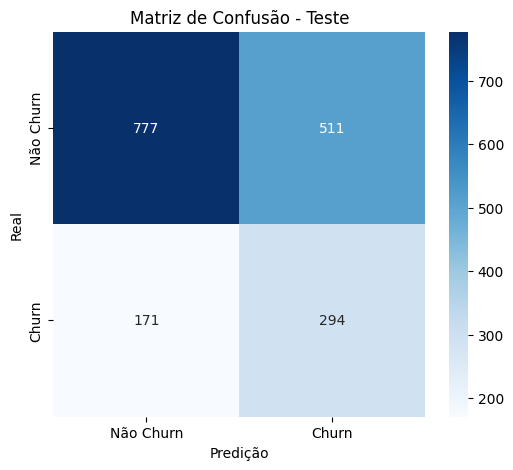

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.674428  0.902764  0.829259   0.793497  0.890182  0.124662   
Validation  0.463509  0.794711  0.729425   0.737349  0.712733  0.189661   
Test        0.491867  0.802683  0.748431   0.518809  0.711828  0.173830   

             LogLoss  
Train       0.396086  
Validation  0.570551  
Test        0.525986  


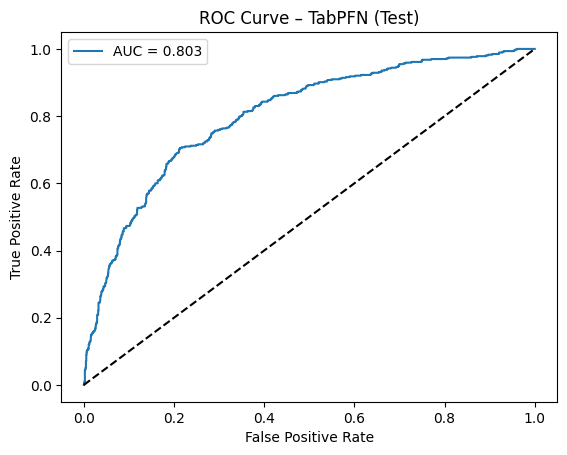

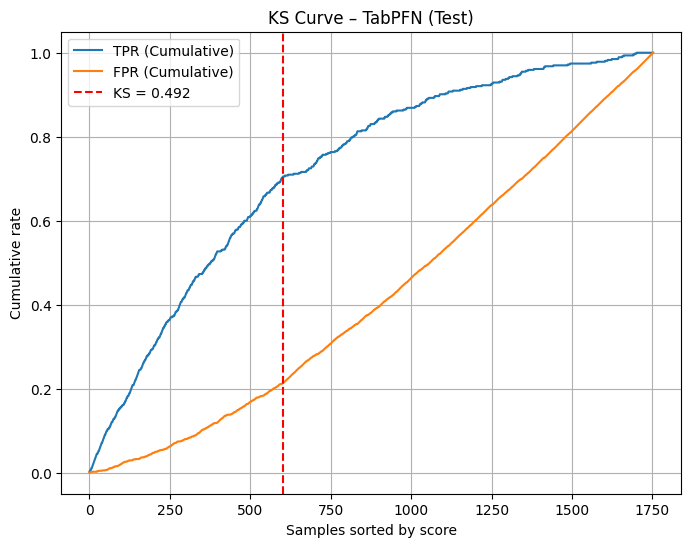

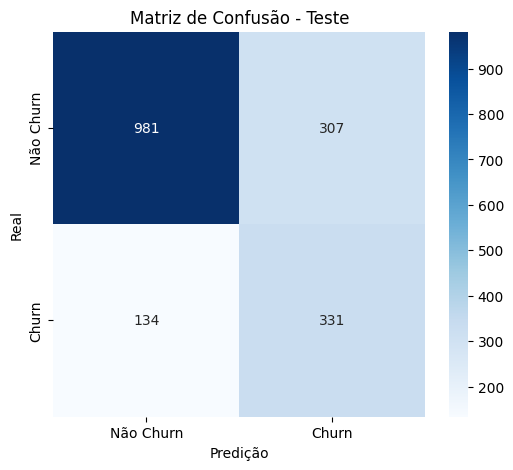

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.849437  0.971688  0.909779   0.864138  0.972449  0.071254   
Validation  0.484472  0.813394  0.729814   0.754296  0.681677  0.186820   
Test        0.498023  0.818532  0.761552   0.538211  0.711828  0.164771   

             LogLoss  
Train       0.251560  
Validation  0.571453  
Test        0.497809  


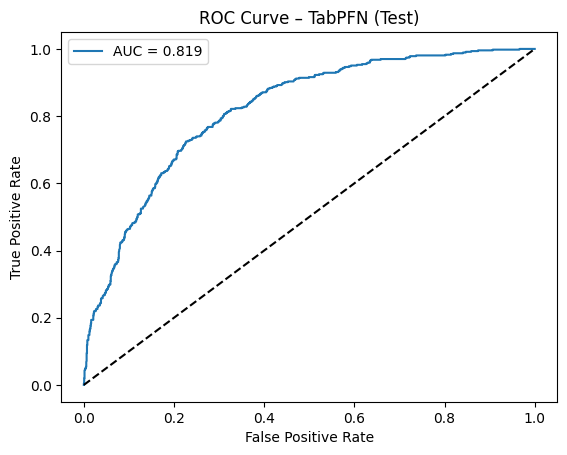

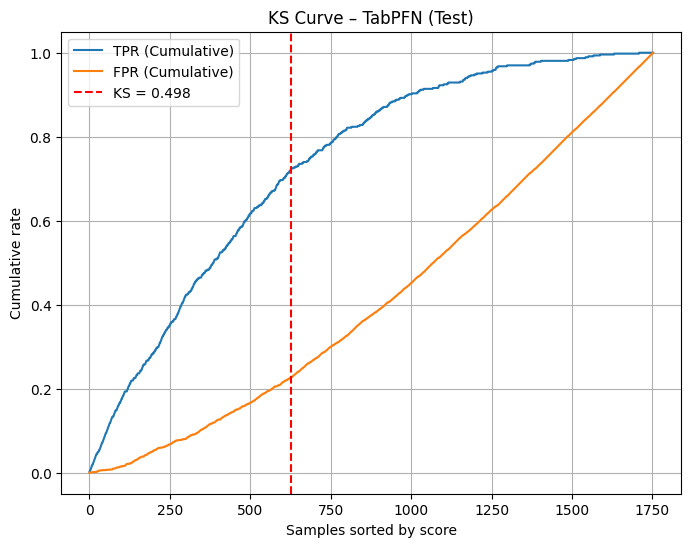

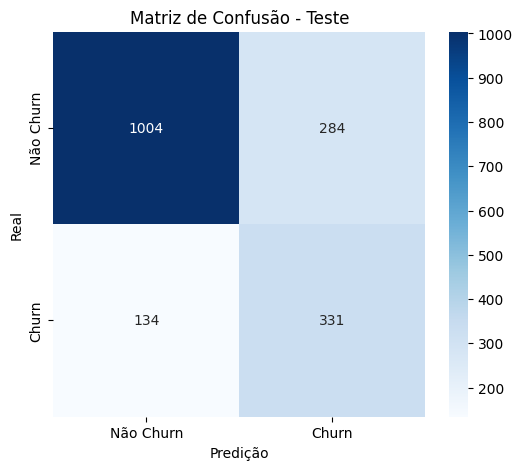

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.922390  0.993111  0.950136   0.922433  0.982926  0.037696   
Validation  0.492236  0.804325  0.684394   0.763012  0.534938  0.212416   
Test        0.486342  0.816137  0.776383   0.578495  0.578495  0.157124   

             LogLoss  
Train       0.145477  
Validation  0.660706  
Test        0.488494  


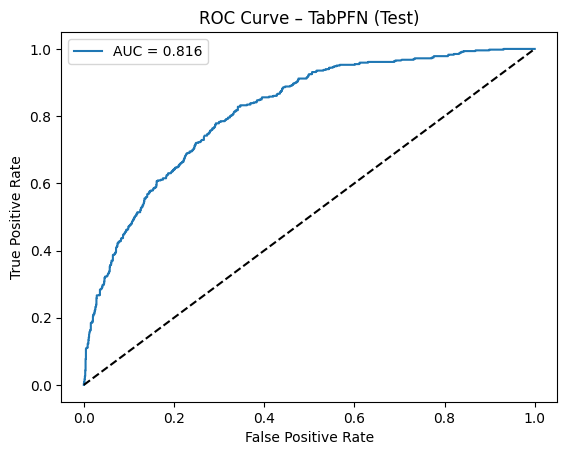

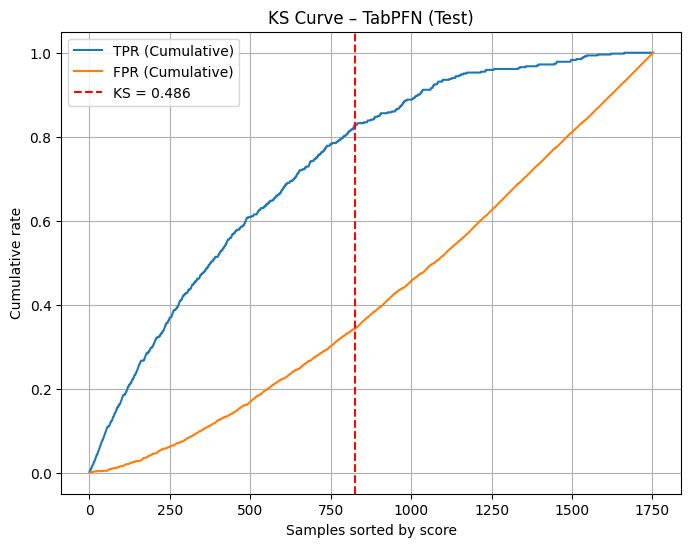

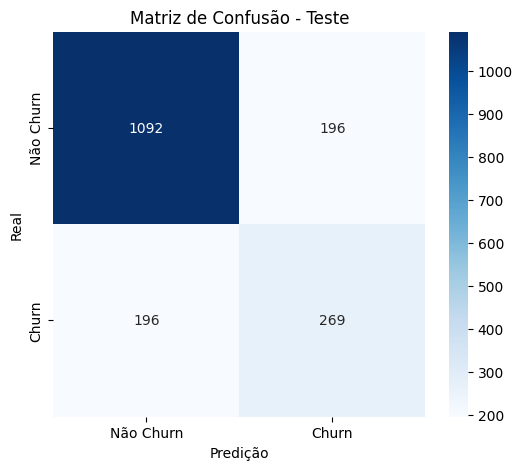

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.931315  0.994992  0.960419   0.937984  0.986030  0.030673   
Validation  0.479814  0.804041  0.680901   0.775414  0.509317  0.220416   
Test        0.464651  0.811733  0.779236   0.589862  0.550538  0.158651   

             LogLoss  
Train       0.119716  
Validation  0.690838  
Test        0.500046  


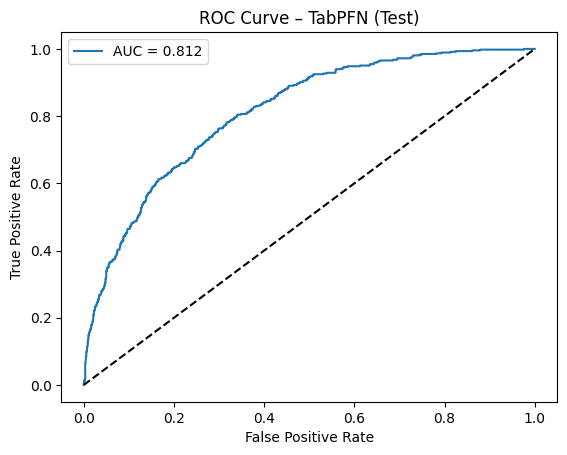

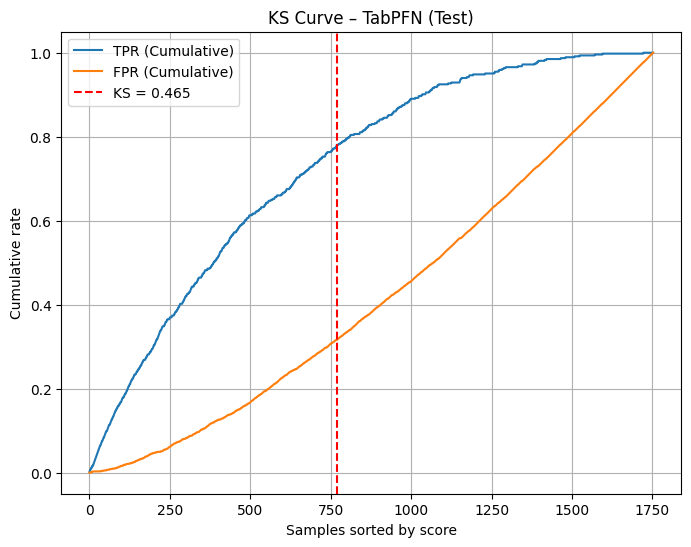

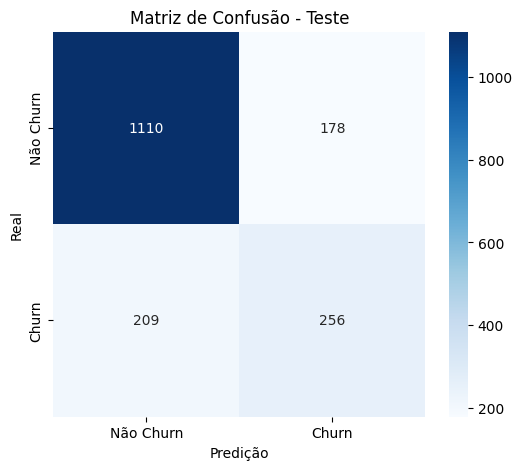

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.929763  0.994567  0.957509   0.935055  0.983314  0.033116   
Validation  0.491460  0.811473  0.684783   0.785372  0.508540  0.216226   
Test        0.473611  0.812053  0.778095   0.588372  0.544086  0.159277   

             LogLoss  
Train       0.127884  
Validation  0.666518  
Test        0.499005  


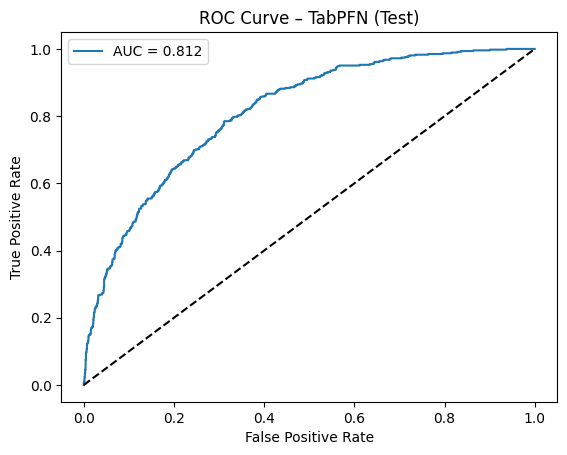

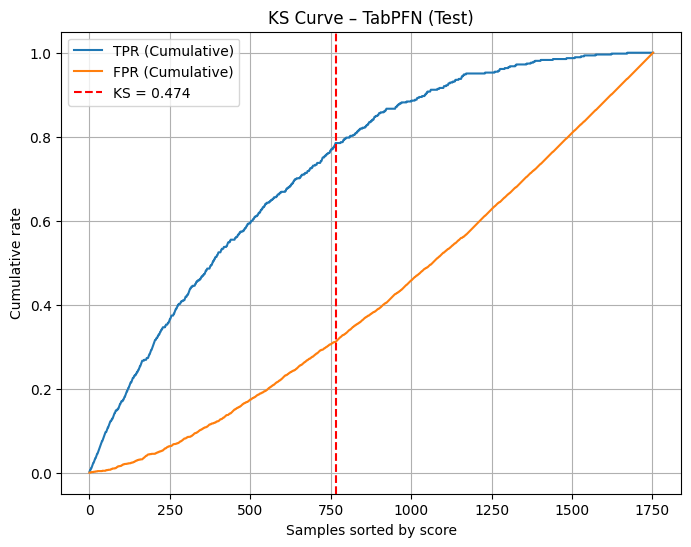

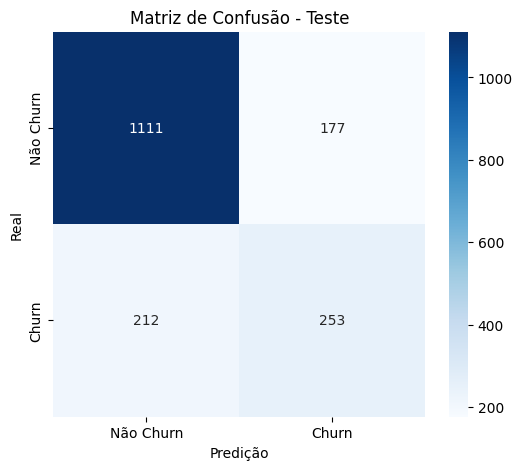

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.930539  0.994978  0.959061   0.937824  0.983314  0.030383   
Validation  0.498447  0.812069  0.683230   0.778960  0.511646  0.215137   
Test        0.477905  0.813179  0.784940   0.603286  0.552688  0.157948   

             LogLoss  
Train       0.119014  
Validation  0.672702  
Test        0.499022  


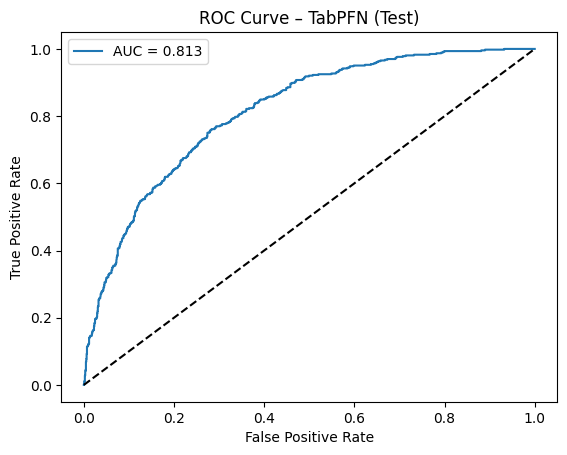

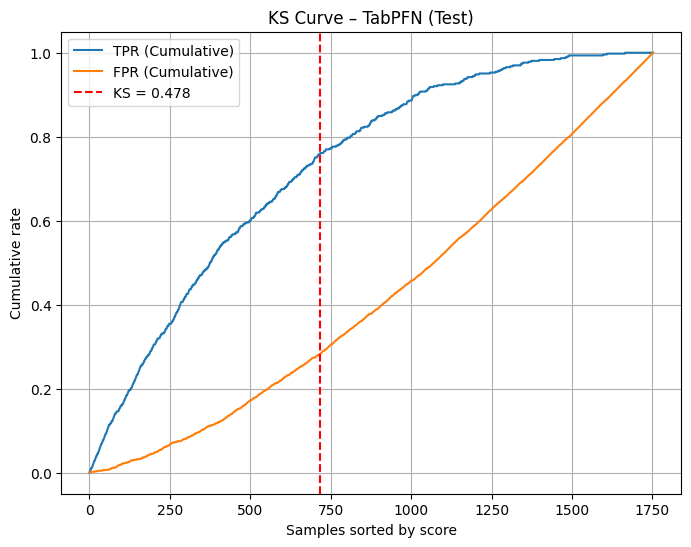

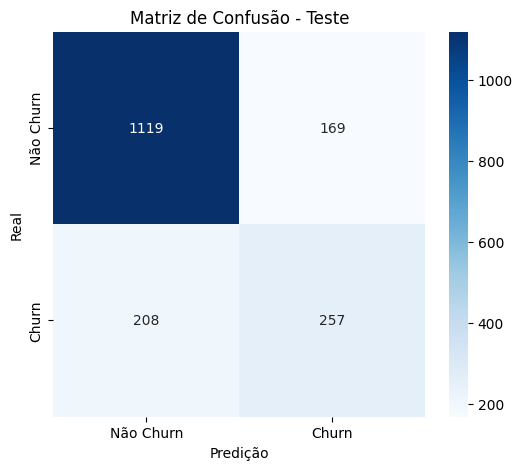

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.924331  0.993752  0.956345   0.929197  0.987971  0.033792   
Validation  0.507764  0.817866  0.693711   0.798088  0.518634  0.209476   
Test        0.502942  0.822721  0.794067   0.625000  0.559140  0.152404   

             LogLoss  
Train       0.131407  
Validation  0.638372  
Test        0.474543  


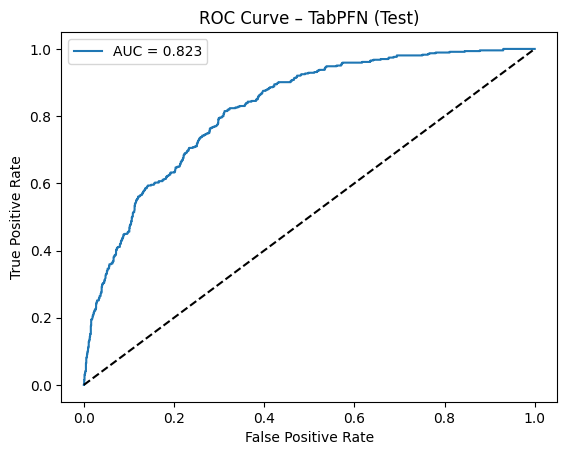

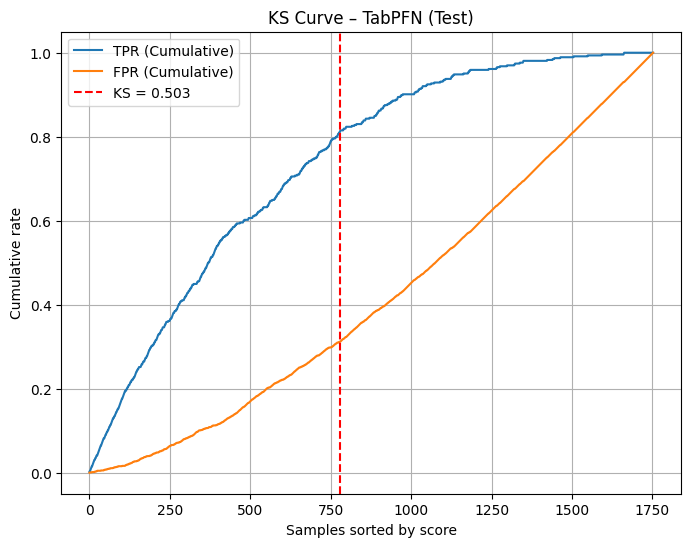

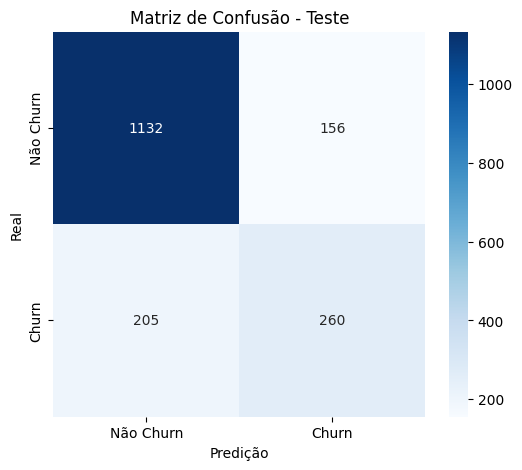

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.925107  0.993796  0.955568   0.931301  0.983702  0.034832   
Validation  0.510870  0.824922  0.704969   0.812057  0.533385  0.203054   
Test        0.490224  0.824266  0.794067   0.626829  0.552688  0.150959   

             LogLoss  
Train       0.135831  
Validation  0.619552  
Test        0.470985  


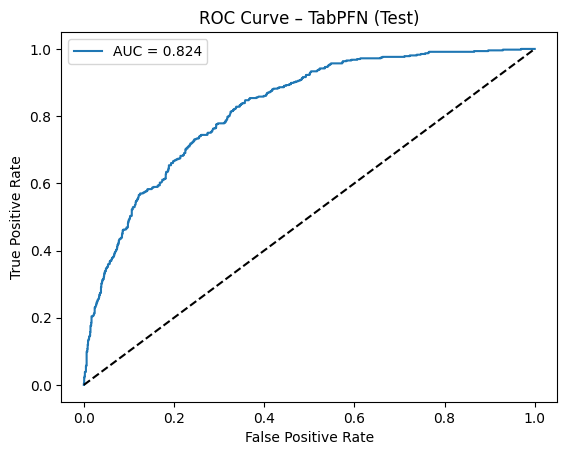

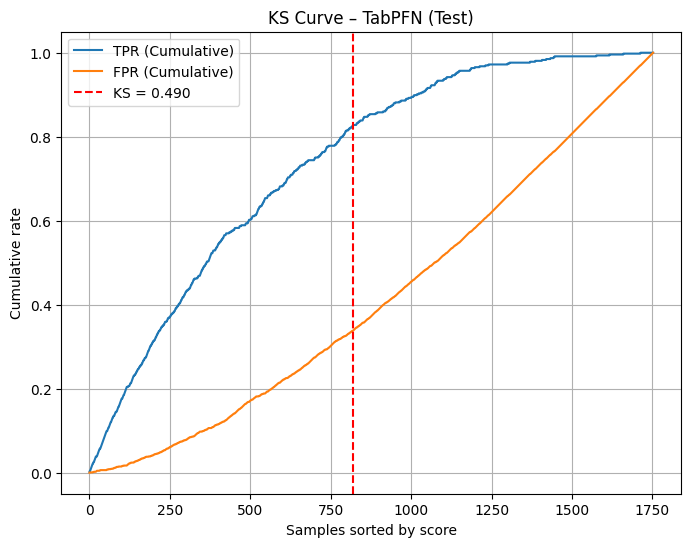

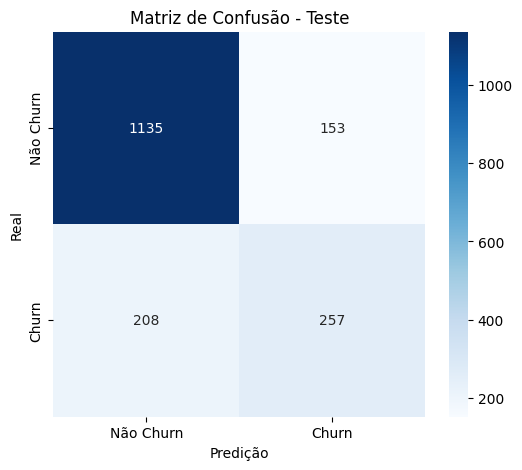

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.926659  0.993799  0.957897   0.930029  0.990299  0.033870   
Validation  0.505435  0.819403  0.697981   0.811736  0.515528  0.208802   
Test        0.481917  0.822432  0.790074   0.622785  0.529032  0.150061   

             LogLoss  
Train       0.133435  
Validation  0.636018  
Test        0.467543  


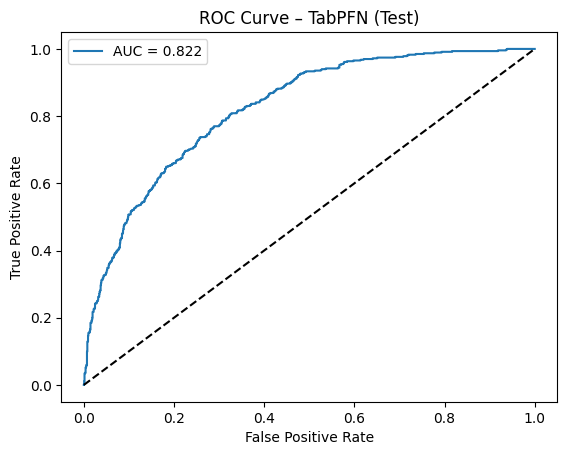

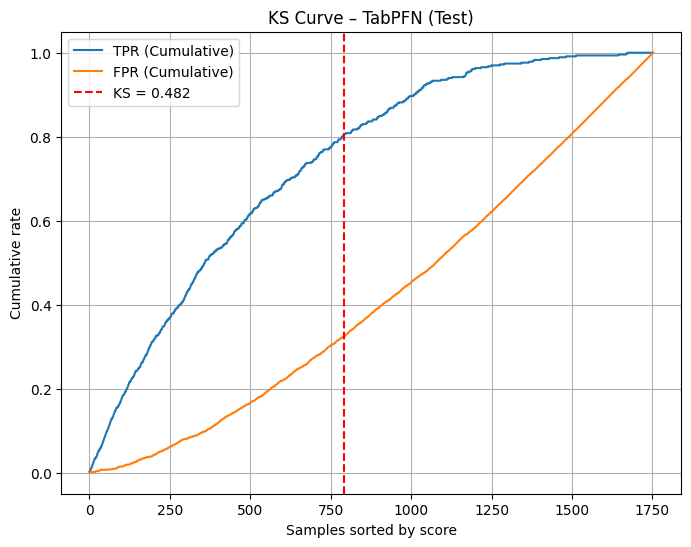

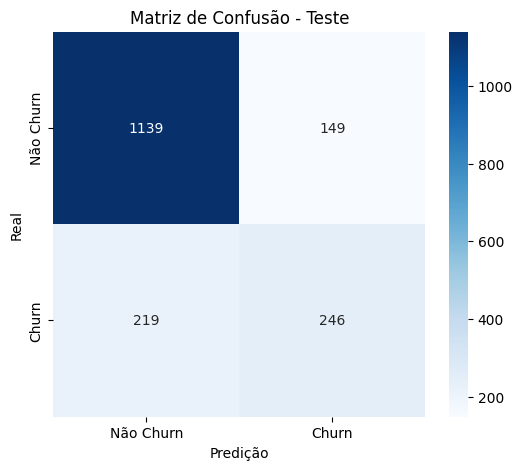

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.925495  0.993810  0.957703   0.934759  0.984090  0.033810   
Validation  0.499224  0.819385  0.682065   0.800256  0.485248  0.210595   
Test        0.500132  0.828270  0.787792   0.618926  0.520430  0.147655   

             LogLoss  
Train       0.132955  
Validation  0.646536  
Test        0.461027  


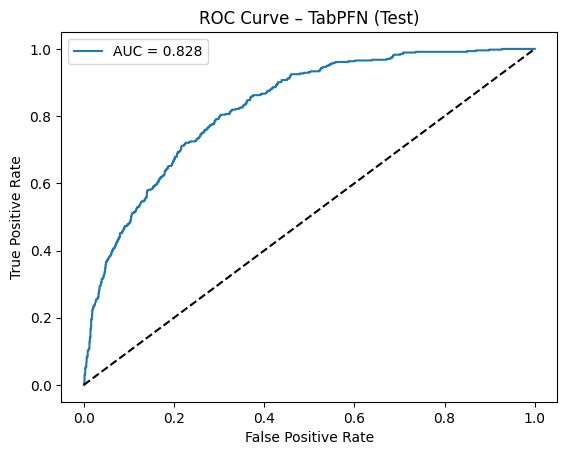

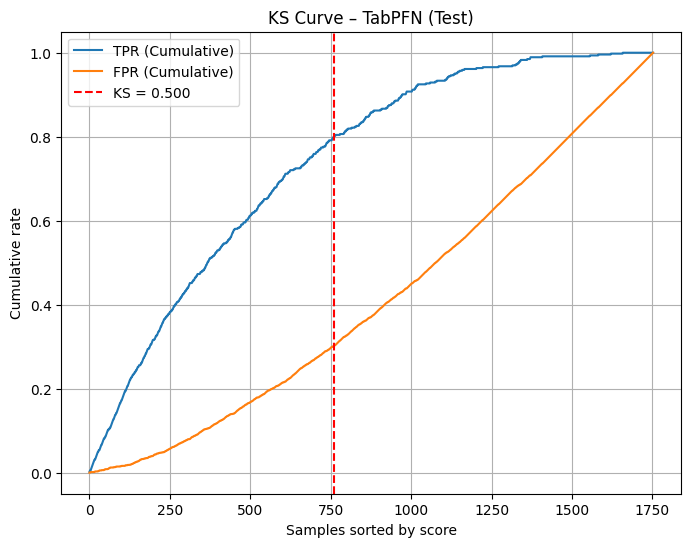

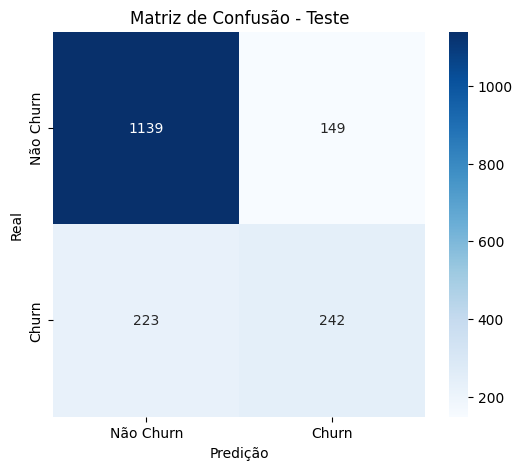

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.919286  0.991785  0.951300   0.918948  0.989911  0.039550   
Validation  0.519410  0.824208  0.708463   0.809689  0.545031  0.200997   
Test        0.508961  0.832222  0.788363   0.610329  0.559140  0.146859   

             LogLoss  
Train       0.152517  
Validation  0.617425  
Test        0.456688  


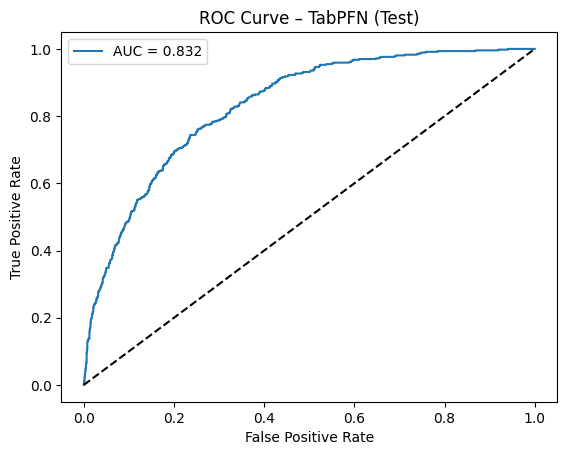

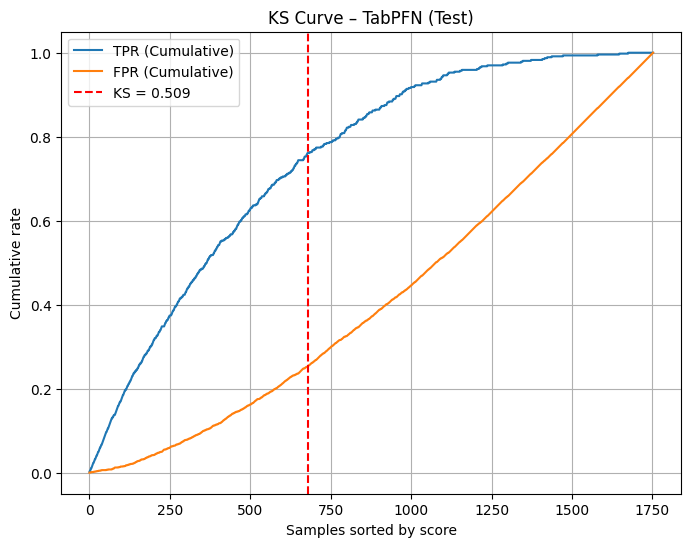

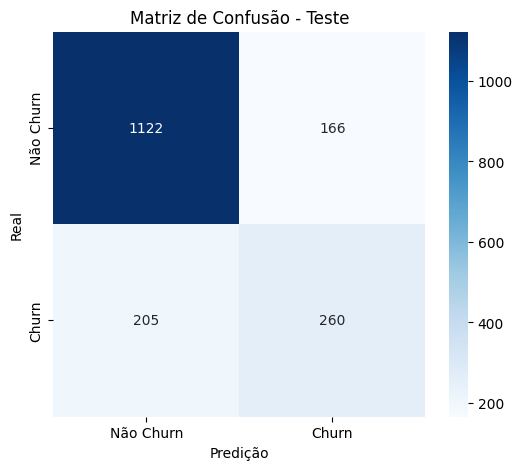

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.916570  0.990831  0.948972   0.920116  0.983314  0.041838   
Validation  0.506211  0.825045  0.708075   0.804545  0.549689  0.198940   
Test        0.512087  0.831392  0.787792   0.610451  0.552688  0.147342   

             LogLoss  
Train       0.161094  
Validation  0.605747  
Test        0.454159  


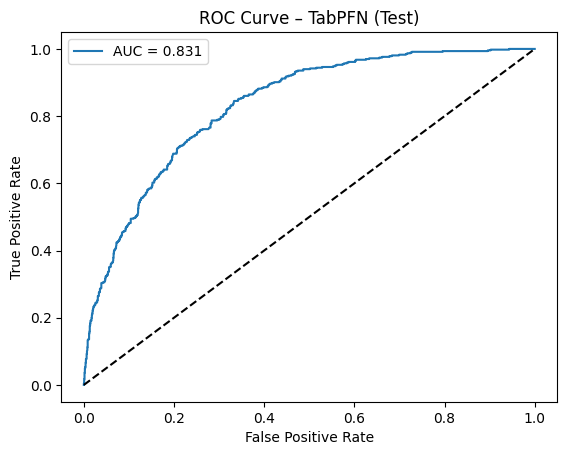

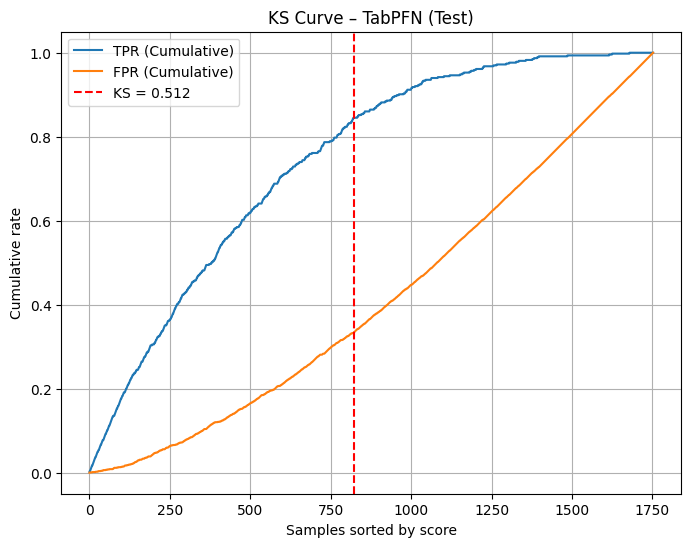

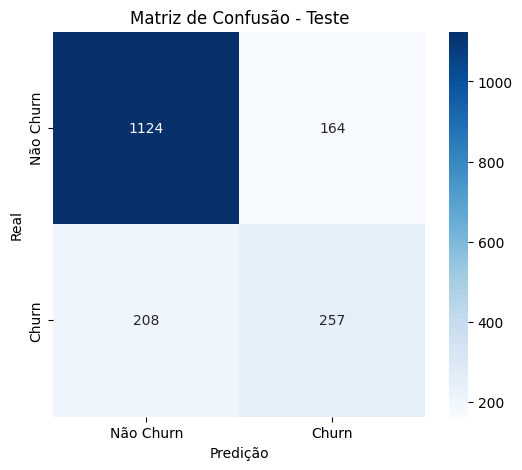

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.916182  0.992476  0.949942   0.922097  0.982926  0.039299   
Validation  0.507764  0.822760  0.697593   0.805522  0.520963  0.204965   
Test        0.507106  0.829403  0.784940   0.607843  0.533333  0.148108   

             LogLoss  
Train       0.151418  
Validation  0.625670  
Test        0.457739  


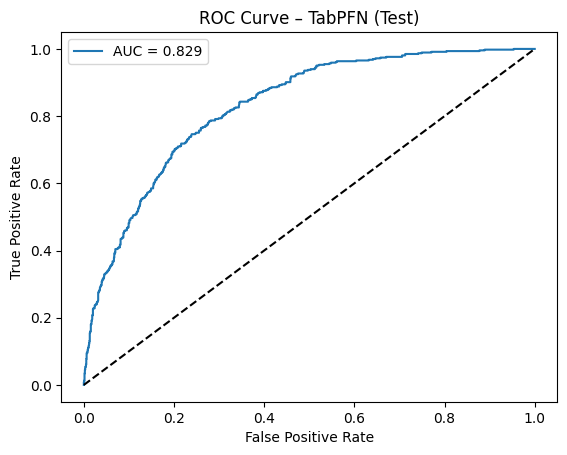

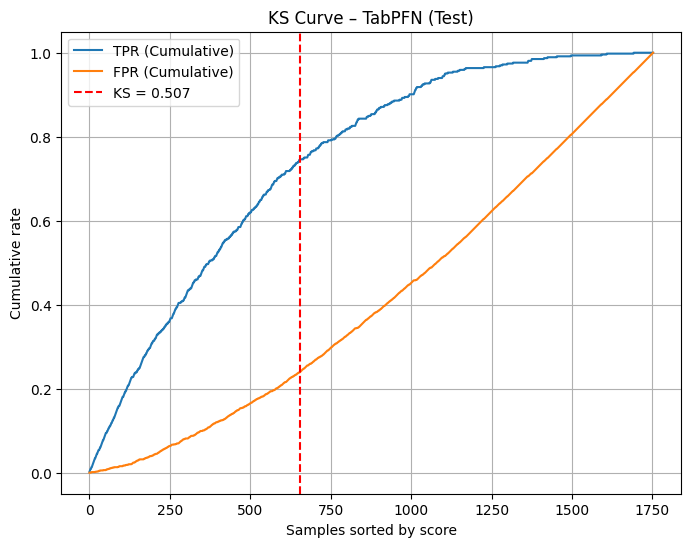

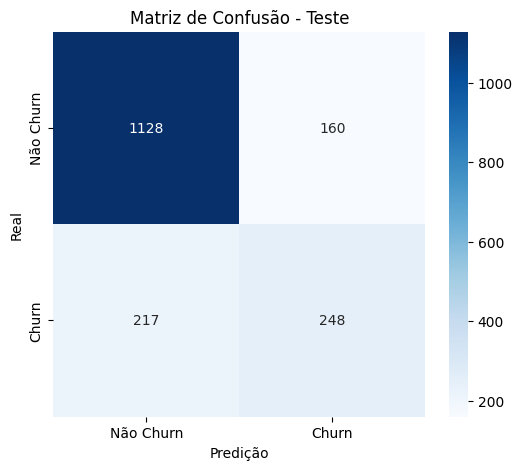

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.907256  0.990498  0.947808   0.921476  0.979045  0.043340   
Validation  0.516304  0.827219  0.710016   0.810563  0.548137  0.197910   
Test        0.508452  0.833519  0.785511   0.605701  0.548387  0.146498   

             LogLoss  
Train       0.166576  
Validation  0.605765  
Test        0.451602  


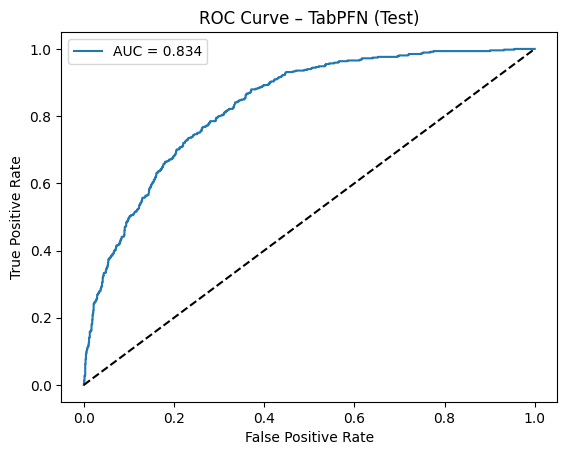

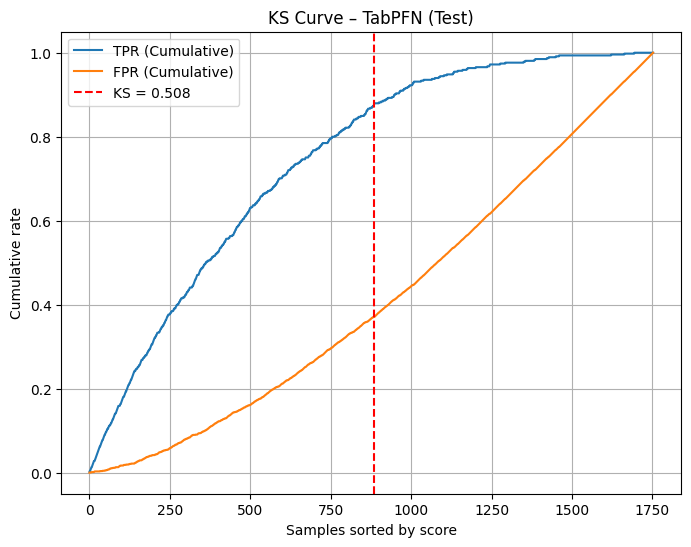

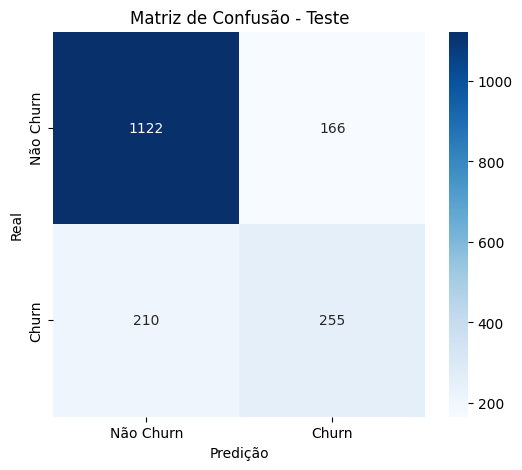

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.910749  0.990217  0.943733   0.908247  0.987194  0.043626   
Validation  0.517081  0.827493  0.721273   0.815965  0.571429  0.196723   
Test        0.508308  0.833495  0.793497   0.617849  0.580645  0.146092   

             LogLoss  
Train       0.167028  
Validation  0.600311  
Test        0.450038  


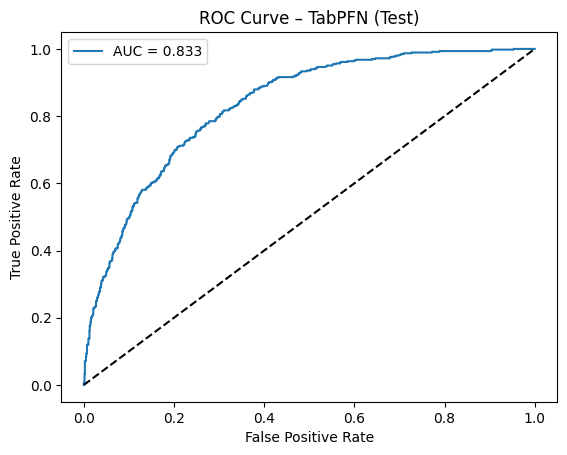

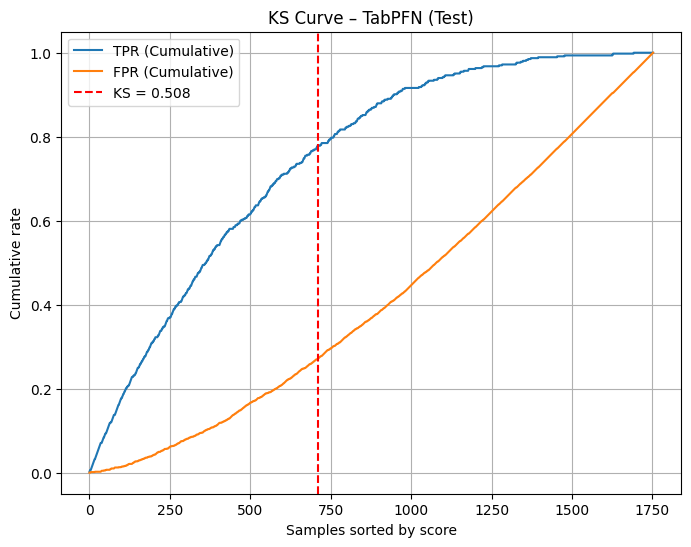

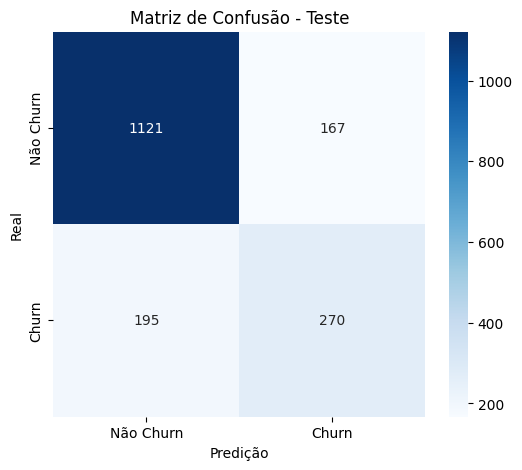

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.891735  0.986237  0.937136   0.896515  0.988359  0.051195   
Validation  0.531832  0.834343  0.725155   0.798354  0.602484  0.185127   
Test        0.515082  0.836345  0.783799   0.587755  0.619355  0.146357   

             LogLoss  
Train       0.193157  
Validation  0.565050  
Test        0.447045  


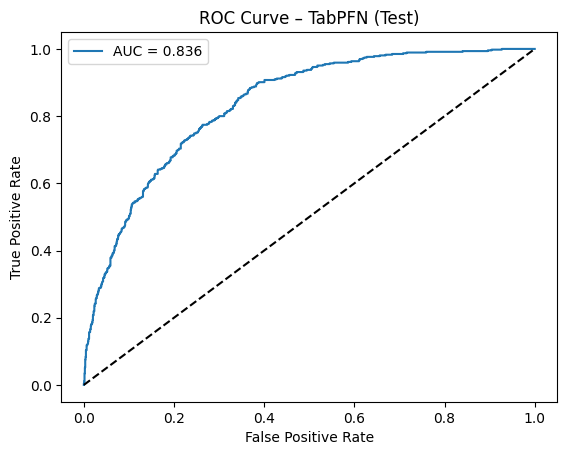

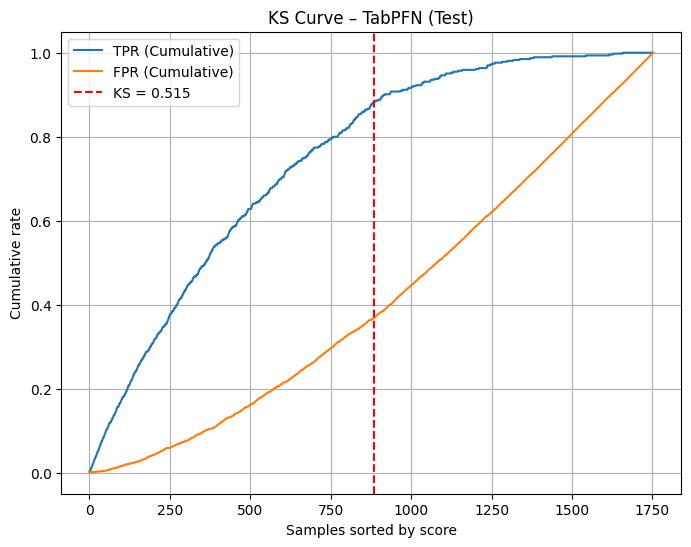

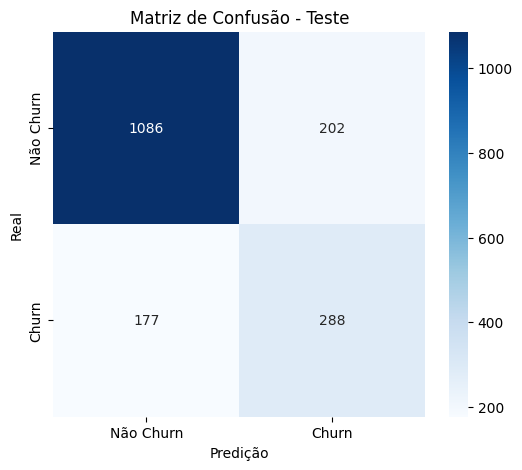

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.887078  0.984096  0.933256   0.891342  0.986806  0.055544   
Validation  0.522516  0.833814  0.738354   0.805169  0.628882  0.182998   
Test        0.512843  0.836522  0.787792   0.592445  0.640860  0.146657   

             LogLoss  
Train       0.207349  
Validation  0.563830  
Test        0.447948  


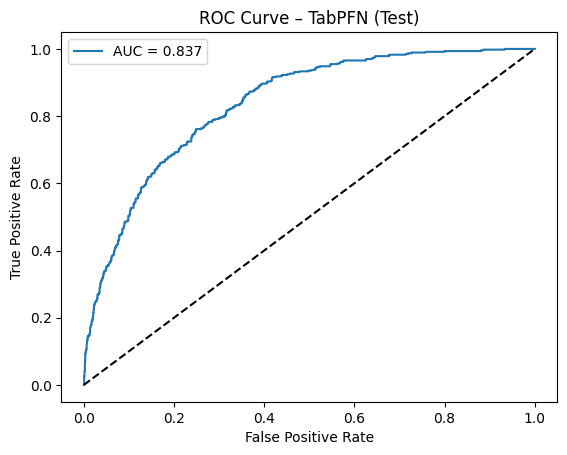

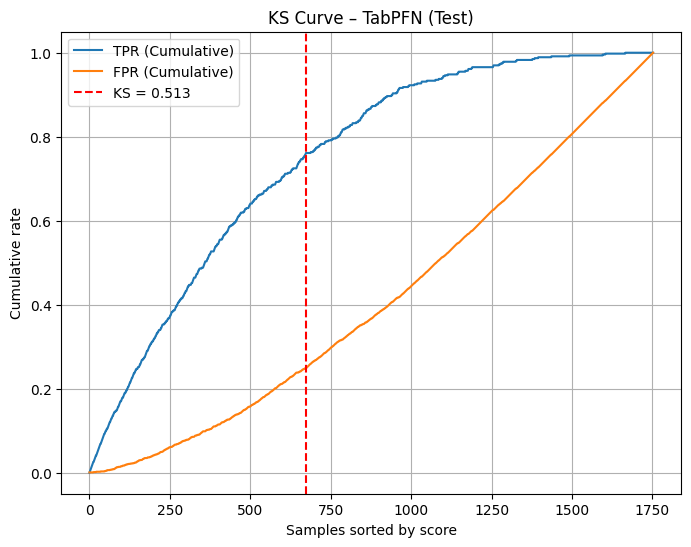

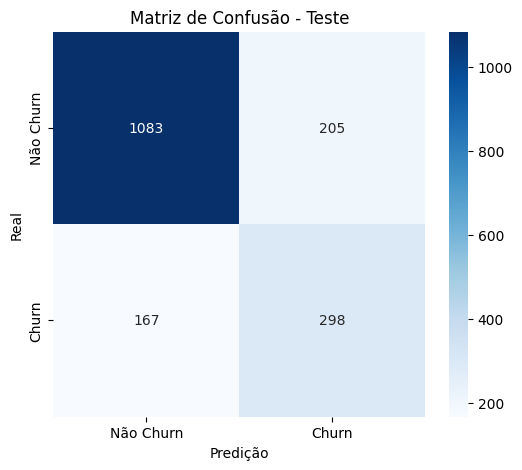

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.883974  0.983270  0.931898   0.888346  0.987971  0.057151   
Validation  0.537267  0.835615  0.737189   0.792905  0.642081  0.179117   
Test        0.515859  0.836813  0.783799   0.582061  0.655914  0.147188   

             LogLoss  
Train       0.212341  
Validation  0.551366  
Test        0.449121  


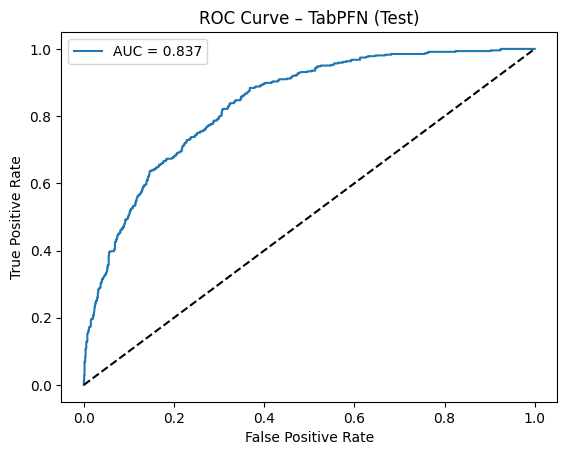

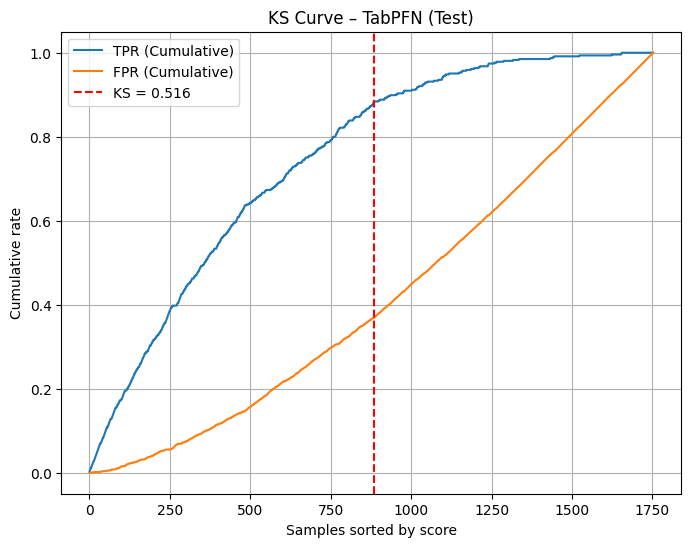

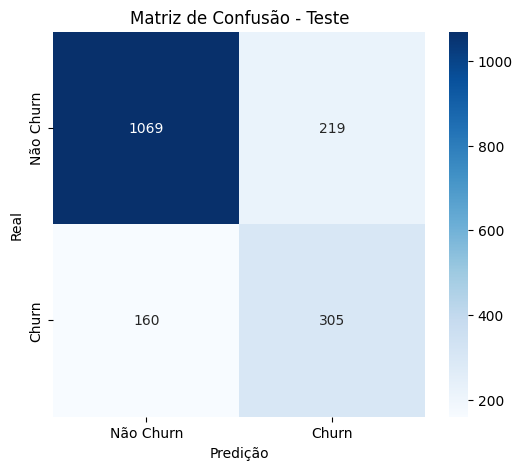

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.890182  0.985410  0.929763   0.886832  0.985254  0.054944   
Validation  0.527174  0.833343  0.737966   0.802567  0.631211  0.182085   
Test        0.524035  0.841369  0.790074   0.595285  0.651613  0.144183   

             LogLoss  
Train       0.203489  
Validation  0.561803  
Test        0.443056  


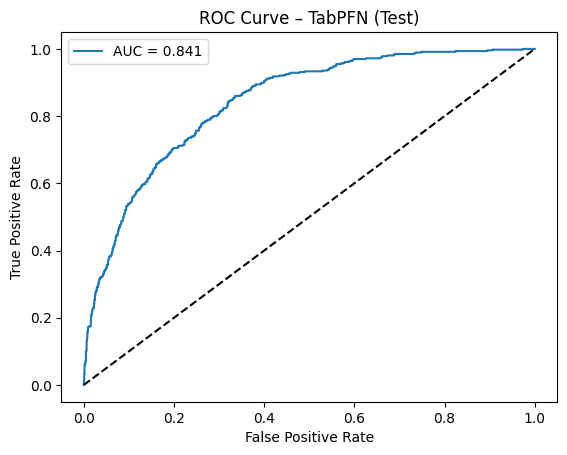

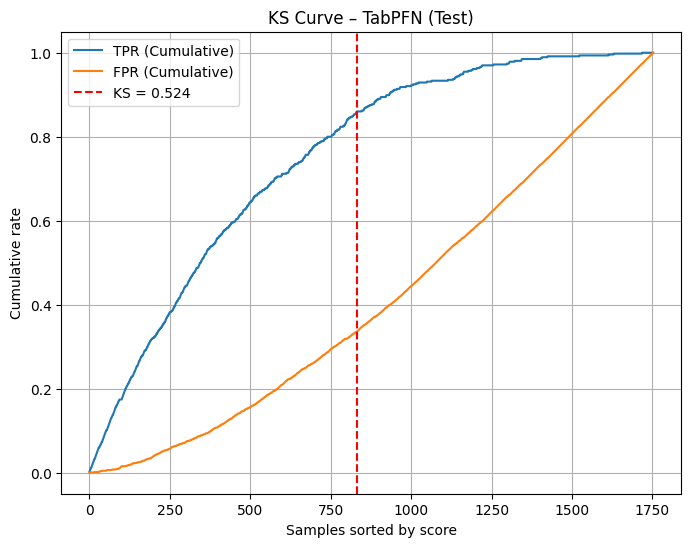

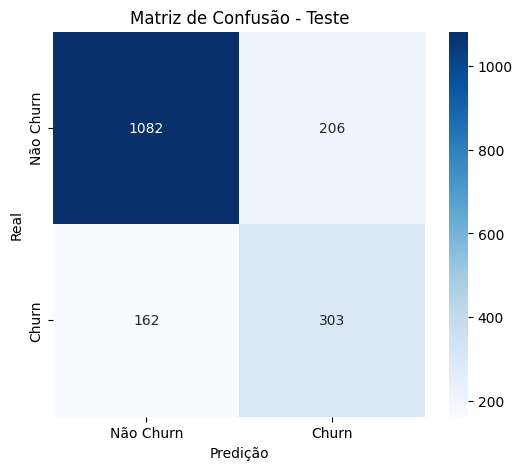

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.883198  0.985295  0.926659   0.880845  0.986806  0.058249   
Validation  0.535714  0.834720  0.740683   0.804519  0.635870  0.179974   
Test        0.526234  0.840193  0.783229   0.582846  0.643011  0.144025   

             LogLoss  
Train       0.214252  
Validation  0.557167  
Test        0.441654  


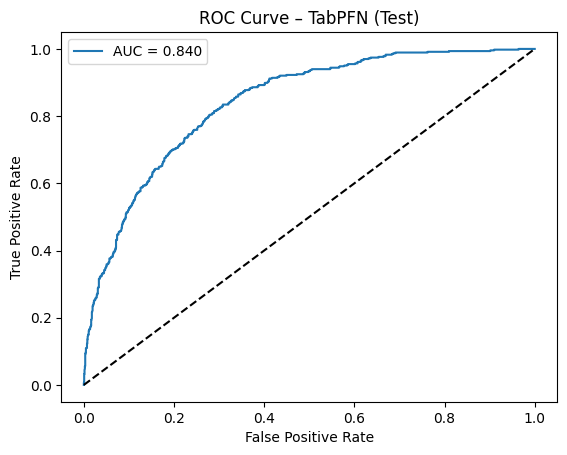

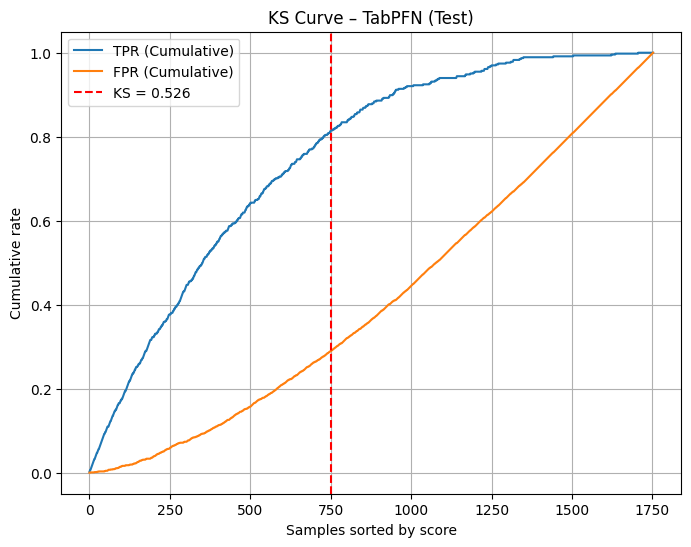

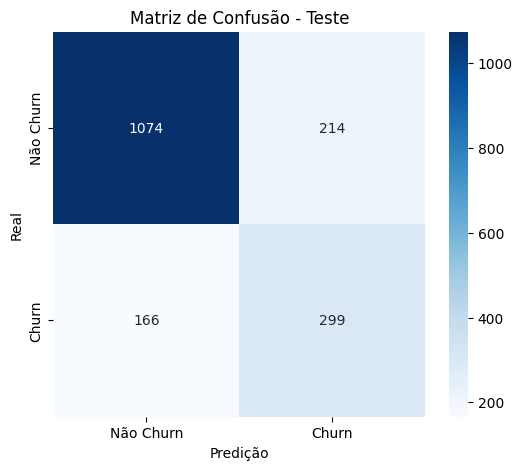

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.871556  0.982555  0.920256   0.871909  0.985254  0.061324   
Validation  0.532609  0.836497  0.743012   0.795283  0.654503  0.177760   
Test        0.527484  0.842800  0.783799   0.579926  0.670968  0.144936   

             LogLoss  
Train       0.221899  
Validation  0.553368  
Test        0.443470  


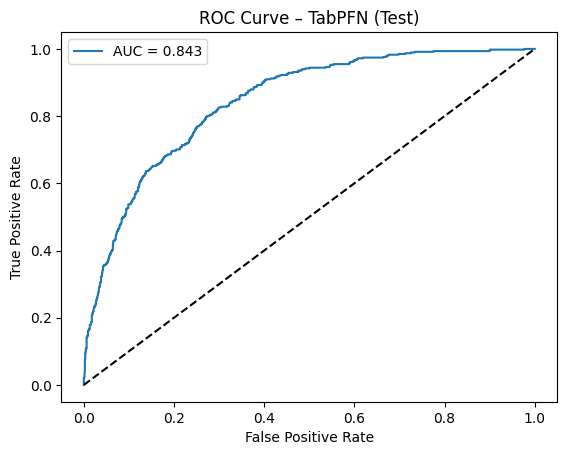

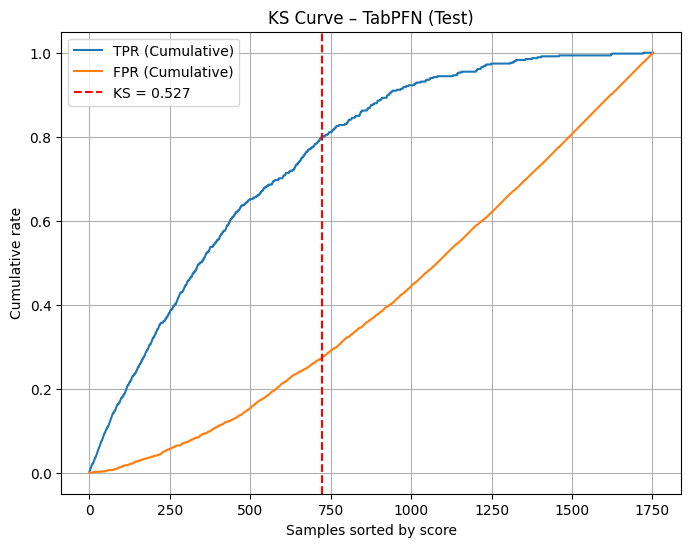

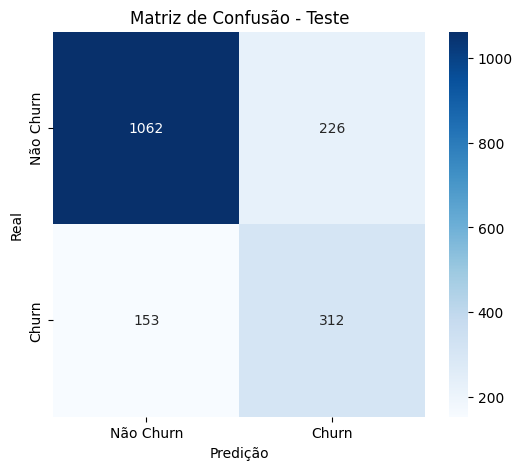

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.898331  0.988242  0.938494   0.899293  0.987582  0.051487   
Validation  0.525621  0.832009  0.720497   0.809368  0.576863  0.188639   
Test        0.529937  0.838623  0.789504   0.604803  0.595699  0.142670   

             LogLoss  
Train       0.192770  
Validation  0.577125  
Test        0.438194  


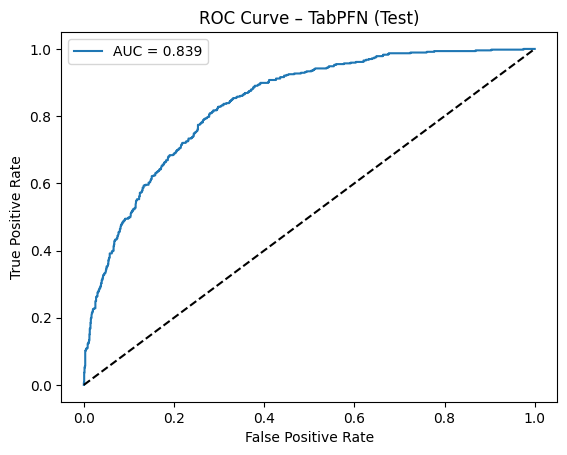

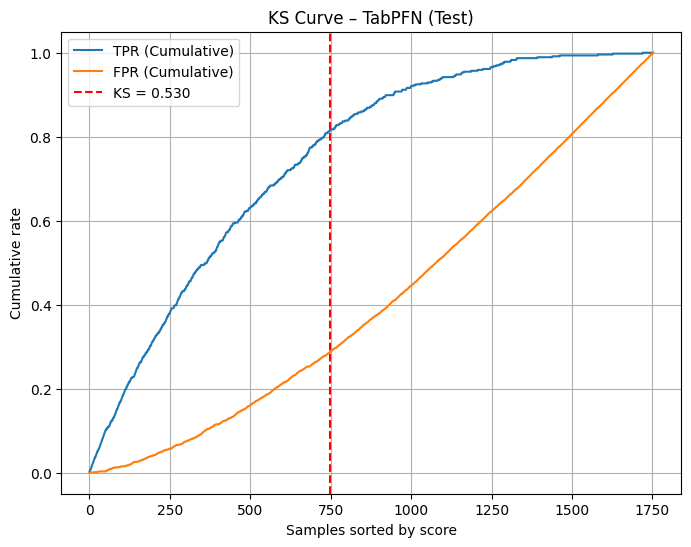

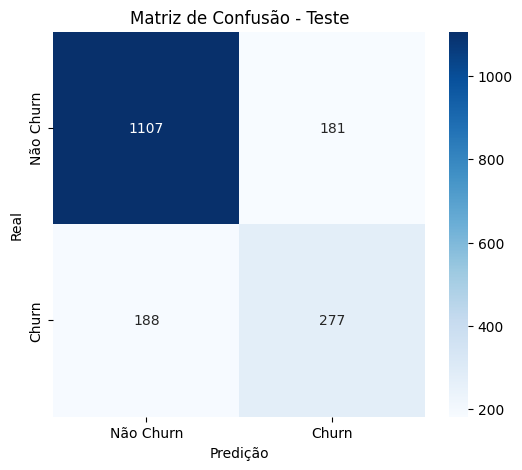

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.852542  0.976461  0.915406   0.866735  0.981762  0.067780   
Validation  0.540373  0.838909  0.750000   0.795956  0.672360  0.173525   
Test        0.532562  0.844011  0.784370   0.580407  0.675269  0.145435   

             LogLoss  
Train       0.241564  
Validation  0.539978  
Test        0.444639  


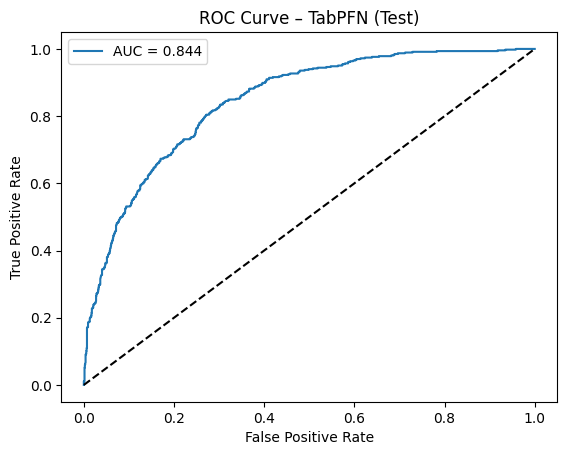

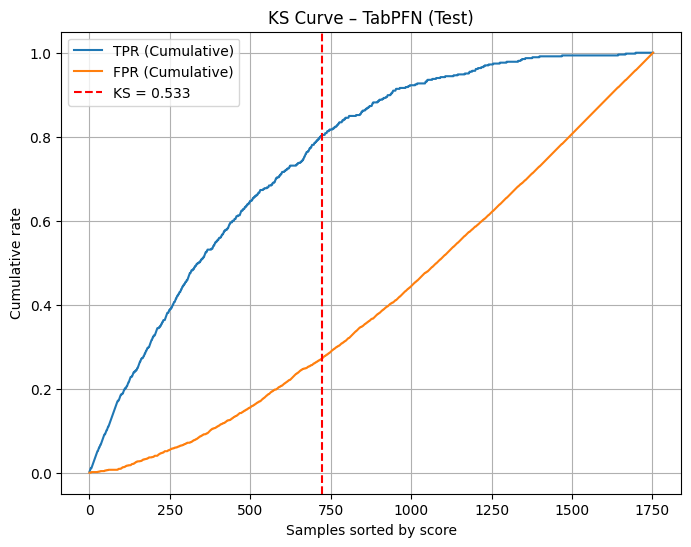

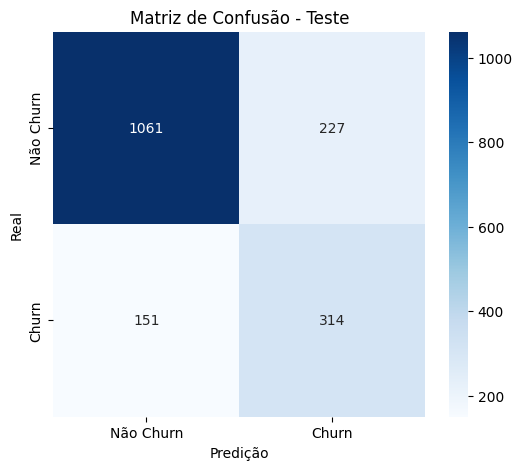

Treinando TabPFN...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Treino concluído!
                  KS   ROC_AUC  Accuracy  Precision    Recall       MSE  \
Train       0.883198  0.984863  0.927241   0.882557  0.985642  0.058355   
Validation  0.536491  0.834428  0.740295   0.800777  0.639752  0.180204   
Test        0.540511  0.842314  0.790645   0.597222  0.647312  0.143126   

             LogLoss  
Train       0.215421  
Validation  0.553916  
Test        0.438597  


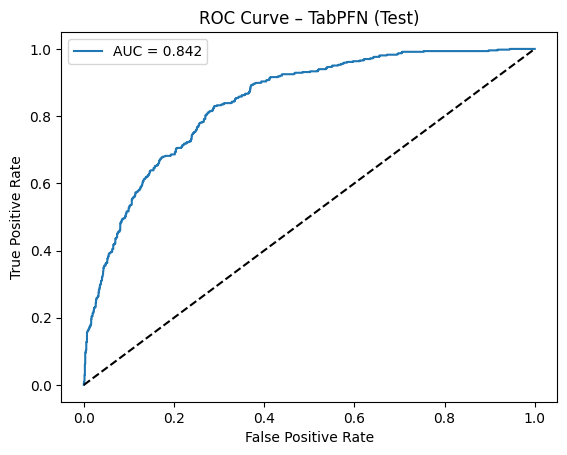

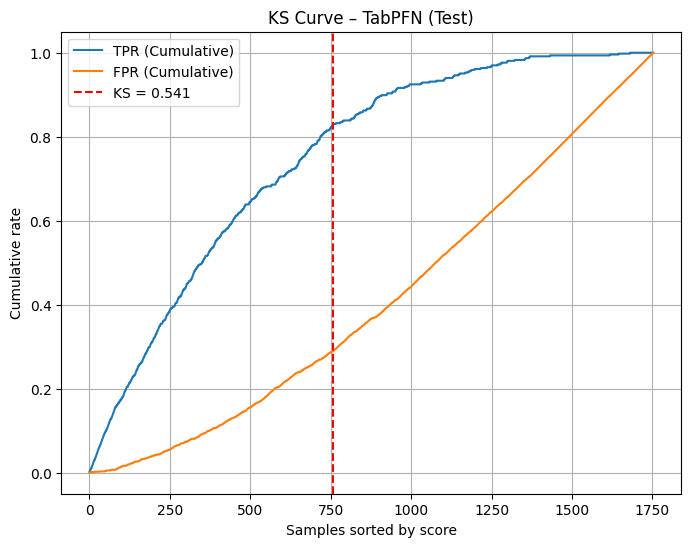

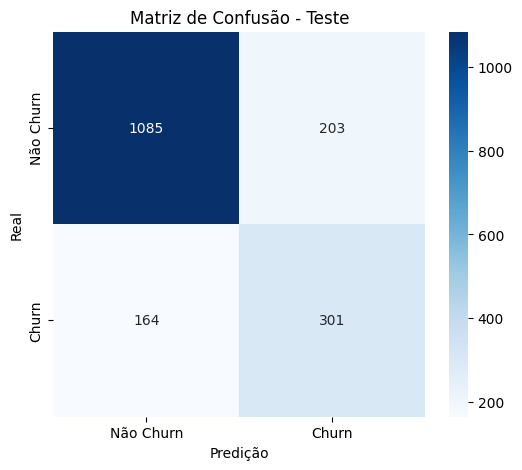

In [ ]:
MAX_COMPONENTS = X_train.shape[1]
results = []

components_range = range(1, MAX_COMPONENTS + 1)

for n_components in components_range:
    X_train_pca = pd.read_csv(f"{DATA_DIR}/X_train_over.csv")
    y_train_pca = pd.read_csv(f"{DATA_DIR}/y_train_over.csv")

    X_val_pca = pd.read_csv(f"{DATA_DIR}/X_val_over.csv")
    y_val_pca = pd.read_csv(f"{DATA_DIR}/y_val_over.csv")

    X_test_pca = pd.read_csv(f"{DATA_DIR}/X_test.csv")
    y_test_pca = pd.read_csv(f"{DATA_DIR}/y_test.csv")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_val_scaled = scaler.transform(X_val_pca)
    X_test_scaled = scaler.transform(X_test_pca)

    n_components = n_components

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model = TabPFNClassifier(model_path='tabpfn-v2-classifier.ckpt')

    print("Treinando TabPFN...")
    model.fit(X_train_pca, y_train_pca)
    print("Treino concluído!")

    # ---------- PREDIÇÕES ----------
    y_train_score = model.predict_proba(X_train_pca)[:, 1]
    y_val_score = model.predict_proba(X_val_pca)[:, 1]
    y_test_score = model.predict_proba(X_test_pca)[:, 1]


    # ---------- MÉTRICAS ----------
    metrics_train = compute_metrics(y_train_pca, y_train_score)
    metrics_val = compute_metrics(y_val_pca, y_val_score)
    metrics_test = compute_metrics(y_test_pca, y_test_score)

    results.append({
        "n_components": n_components,
        "explained_variance": pca.explained_variance_ratio_.sum(),

        "train_ks": metrics_train["KS"],
        "val_ks":   metrics_val["KS"],
        "test_ks":  metrics_test["KS"],

        "train_auc": metrics_train["ROC_AUC"],
        "val_auc":   metrics_val["ROC_AUC"],
        "test_auc":  metrics_test["ROC_AUC"],

        "train_logloss": metrics_train["LogLoss"],
        "val_logloss":   metrics_val["LogLoss"],
        "test_logloss":  metrics_test["LogLoss"],

        "train_mse": metrics_train["MSE"],
        "val_mse":   metrics_val["MSE"],
        "test_mse":  metrics_test["MSE"],

        "train_recall": metrics_train["Recall"],
        "val_recall":   metrics_val["Recall"],
        "test_recall":  metrics_test["Recall"],
    })



    metrics_df = pd.DataFrame([
    metrics_train,
    metrics_val,
    metrics_test
    ], index=["Train", "Validation", "Test"])


    print(metrics_df)


    # ---------- GRÁFICOS (TESTE) ----------


    plot_roc(y_test_pca, y_test_score, "ROC Curve – TabPFN (Test)")
    ks_cumulative(y_test_pca, y_test_score, plot=True, title="KS Curve – TabPFN (Test)")
    plot_conf_matrix(y_test_pca, y_test_score, threshold=0.5, title="Confusion Matrix – TabPFN (Test)")

In [ ]:
print(results)

[{'n_components': 1, 'explained_variance': np.float64(0.20921146103743907), 'train_ks': np.float64(0.22778424524641055), 'val_ks': np.float64(0.19487577639751552), 'test_ks': np.float64(0.23617845455152614), 'train_auc': np.float64(0.6491873350851967), 'val_auc': np.float64(0.6161763145711971), 'test_auc': np.float64(0.6277633072864489), 'train_logloss': 0.6571922453739094, 'val_logloss': 0.6754063595549534, 'test_logloss': 0.6629897150461902, 'train_mse': 0.23278021812438965, 'val_mse': 0.24079042673110962, 'test_mse': 0.23580694198608398, 'train_recall': 0.6065192083818394, 'val_recall': 0.5861801242236024, 'test_recall': 0.632258064516129}, {'n_components': 2, 'explained_variance': np.float64(0.3532920921768695), 'train_ks': np.float64(0.6744276290259992), 'val_ks': np.float64(0.46350931677018636), 'test_ks': np.float64(0.4918670273158351), 'train_auc': np.float64(0.9027642066343429), 'val_auc': np.float64(0.7947112741599475), 'test_auc': np.float64(0.8026831630267816), 'train_loglo

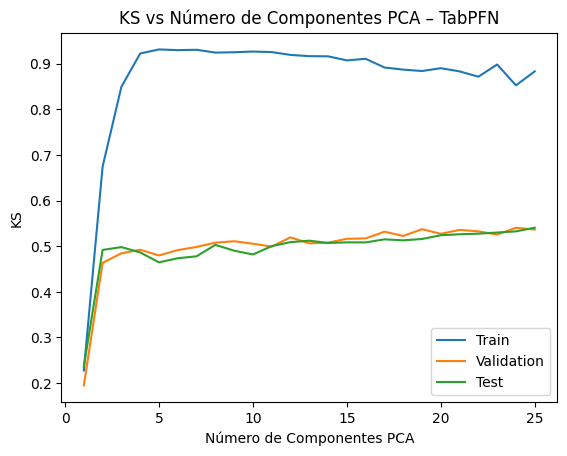

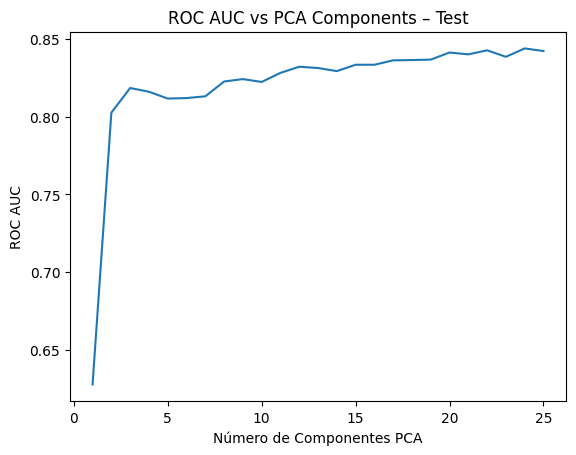

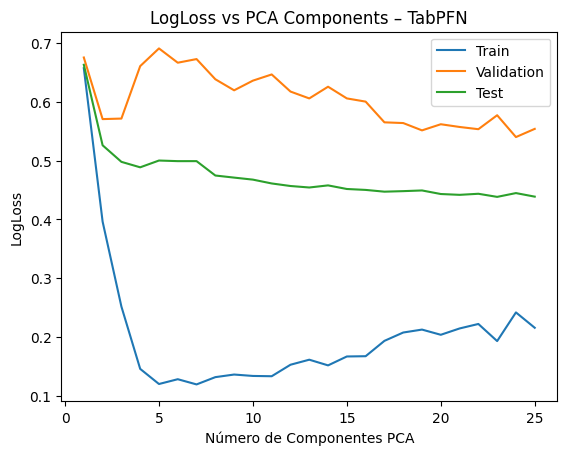

In [ ]:
results_df = pd.DataFrame(results)

plt.figure()
plt.plot(results_df["n_components"], results_df["train_ks"], label="Train")
plt.plot(results_df["n_components"], results_df["val_ks"], label="Validation")
plt.plot(results_df["n_components"], results_df["test_ks"], label="Test")
plt.xlabel("Número de Componentes PCA")
plt.ylabel("KS")
plt.title("KS vs Número de Componentes PCA – TabPFN")
plt.legend()
plt.show()

plt.figure()
plt.plot(results_df["n_components"], results_df["test_auc"])
plt.xlabel("Número de Componentes PCA")
plt.ylabel("ROC AUC")
plt.title("ROC AUC vs PCA Components – Test")
plt.show()

plt.figure()
plt.plot(results_df["n_components"], results_df["train_logloss"], label="Train")
plt.plot(results_df["n_components"], results_df["val_logloss"], label="Validation")
plt.plot(results_df["n_components"], results_df["test_logloss"], label="Test")
plt.xlabel("Número de Componentes PCA")
plt.ylabel("LogLoss")
plt.title("LogLoss vs PCA Components – TabPFN")
plt.legend()
plt.show()
